In [3]:
import random
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, struct, col
from scipy.spatial import ConvexHull
import pandas as pd


In [4]:

# Initialize Spark session
spark = SparkSession.builder.appName("ConvexHullPerParticle").getOrCreate()


In [5]:

# Generate sample data with 1,000,000 data points
num_points = 1000000
num_particles = 10000  # Assuming we have 10,000 particles
data = [(random.randint(1, num_particles), random.randint(0, 1000), random.randint(0, 1000)) for _ in range(num_points)]


In [6]:

# Create DataFrame
columns = ["particle_id", "x", "y"]
df = spark.createDataFrame(data, columns)


In [7]:
# Group by particle_id and collect points
grouped_df = df.groupBy("particle_id").agg(
    collect_list(struct("x", "y")).alias("points")
)


In [8]:

# Define a function to compute convex hull
def compute_convex_hull(points):
    points = [(p['x'], p['y']) for p in points]
    if len(points) < 3:
        return points  # Convex hull is the same as the points if less than 3 points
    hull = ConvexHull(points)
    hull_points = [points[i] for i in hull.vertices]
    return hull_points


In [9]:

# Register the UDF
from pyspark.sql.types import ArrayType, StructType, StructField, IntegerType

hull_schema = ArrayType(StructType([StructField("x", IntegerType()), StructField("y", IntegerType())]))
compute_convex_hull_udf = spark.udf.register("compute_convex_hull", compute_convex_hull, hull_schema)


In [10]:

# Apply the UDF
result_df = grouped_df.withColumn("convex_hull", compute_convex_hull_udf(col("points")))

# Show the result (only showing a small sample due to the large dataset)
result_df.select("particle_id", "convex_hull").show(10, truncate=False)


+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|particle_id|convex_hull                                                                                                                                                                         |
+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|7          |[{998, 173}, {997, 912}, {932, 941}, {50, 985}, {26, 821}, {13, 729}, {5, 284}, {3, 124}, {164, 12}, {579, 5}, {985, 9}]                                                            |
|19         |[{885, 1}, {980, 365}, {958, 599}, {908, 842}, {799, 988}, {286, 998}, {127, 946}, {15, 792}, {28, 288}, {202, 8}]                                                                  |
|22         |[{20, 967}, 

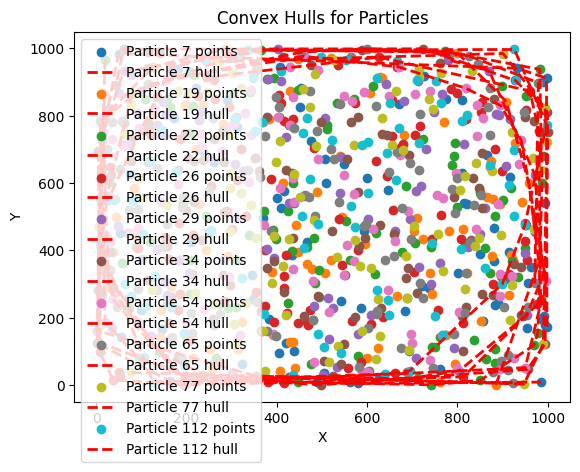

In [13]:
# Collect results to a Pandas DataFrame
result_pd_df = result_df.toPandas()

# Convert convex hull points from Row to list of tuples for easier handling in visualization
result_pd_df['convex_hull'] = result_pd_df['convex_hull'].apply(lambda ch: [(point['x'], point['y']) for point in ch])

# Visualization
fig, ax = plt.subplots()

# Plot points and their convex hulls for a few particles
num_particles_to_plot = 10
for index, row in result_pd_df.head(num_particles_to_plot).iterrows():
    particle_id = row['particle_id']
    points = row['points']
    convex_hull = row['convex_hull']
    
    # Plot points
    x_points, y_points = zip(*[(p['x'], p['y']) for p in points])
    ax.scatter(x_points, y_points, label=f'Particle {particle_id} points')
    
    # Plot convex hull
    hull_x, hull_y = zip(*convex_hull)
    ax.plot(hull_x, hull_y, 'r--', lw=2, label=f'Particle {particle_id} hull')

ax.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Convex Hulls for Particles')
plt.show()

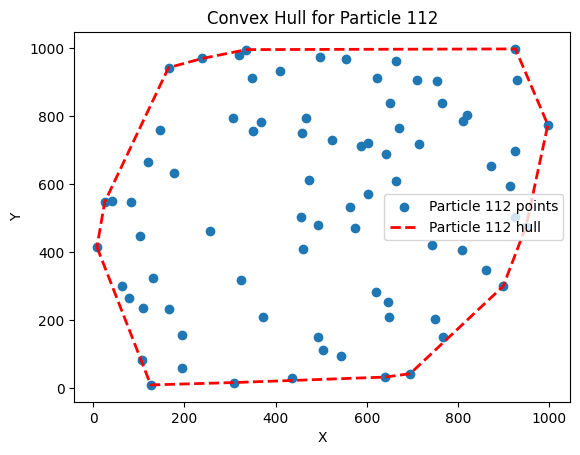

In [14]:
# Plot points and convex hull
fig, ax = plt.subplots()

# Plot points
x_points, y_points = zip(*[(p['x'], p['y']) for p in points])
ax.scatter(x_points, y_points, label=f'Particle {particle_id} points')

# Plot convex hull
hull_x, hull_y = zip(*convex_hull)
# Append the first point to close the hull
hull_x += (hull_x[0],)
hull_y += (hull_y[0],)
ax.plot(hull_x, hull_y, 'r--', lw=2, label=f'Particle {particle_id} hull')

ax.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Convex Hull for Particle {particle_id}')
plt.show()

In [ ]:

# Stop the Spark session
spark.stop()
